# Desafio Ciencia de dados Cinnecta

Nesse notebook realizei uma analise exploratoria dos dados, seguida de limpeza e feature engineering dos mesmos com o intuito prepara-los para treinar um modelo preditivo de precos dos anuncios do Airbnb. Alem disso, no final tambem comparei brevemente o desempenho do modelo XGBoost com uma Regressao Linear Multipla.

### Imports

In [486]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb

import geopandas as gpd

from shapely.geometry import Point
from geopy.geocoders import Nominatim

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error



%matplotlib inline

### Load data

In [487]:
df = pd.read_excel('data/airbnb_raw_data.xlsx')

### Exploratory analisys and feature engineering

#### Avaliable features

In [488]:
df.head()

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,neighbourhood_cleansed,latitude,longitude,property_type,room_type,accommodates,...,bedrooms_na,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na
0,t,moderate,t,1.0,Western Addition,3776931.0,-12243386.0,Apartment,Entire home/apt,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,f,strict_14_with_grace_period,f,2.0,Bernal Heights,3774511.0,-12242102.0,Apartment,Entire home/apt,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,f,strict_14_with_grace_period,f,10.0,Haight Ashbury,3776669.0,-1224525.0,Apartment,Private room,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f,strict_14_with_grace_period,f,10.0,Haight Ashbury,3776487.0,-12245183.0,Apartment,Private room,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f,strict_14_with_grace_period,f,2.0,Western Addition,3777525.0,-12243637.0,House,Entire home/apt,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Conferindo a qualidade de nulos nas colunas

In [489]:
df.isna().mean()

host_is_superhost                 0.0
cancellation_policy               0.0
instant_bookable                  0.0
host_total_listings_count         0.0
neighbourhood_cleansed            0.0
latitude                          0.0
longitude                         0.0
property_type                     0.0
room_type                         0.0
accommodates                      0.0
bathrooms                         0.0
bedrooms                          0.0
beds                              0.0
bed_type                          0.0
minimum_nights                    0.0
number_of_reviews                 0.0
review_scores_rating              0.0
review_scores_accuracy            0.0
review_scores_cleanliness         0.0
review_scores_checkin             0.0
review_scores_communication       0.0
review_scores_location            0.0
review_scores_value               0.0
price                             0.0
bedrooms_na                       0.0
bathrooms_na                      0.0
beds_na     

#### Os valores de latitude e longitude nao estao com as casas decimais nos lugares corretos, ja que os valores aceitos sao entre -90 e 90 para latitude e -180 e 180 para longitude

In [490]:
df[['latitude','longitude']].head()

,latitude,longitude
0,3776931.0,-12243386.0
1,3774511.0,-12242102.0
2,3776669.0,-1224525.0
3,3776487.0,-12245183.0
4,3777525.0,-12243637.0


#### Testando alteracoes nas casas decimais criei a hipotese de que os valores foram arredondados as casas decimais com zero foram descartadas, alem do ponto decimal original ter se perdido, dessa forma vou assumir que o numero de casas decimais esta correto nos pontos que se encontram nos Estados Unidos, ja que sao a maior parte dos pontos e tambem por fazer mais sentido intuitivamente

In [491]:
latitude = df.latitude/100000
longitude = df.longitude/100000

<AxesSubplot:>

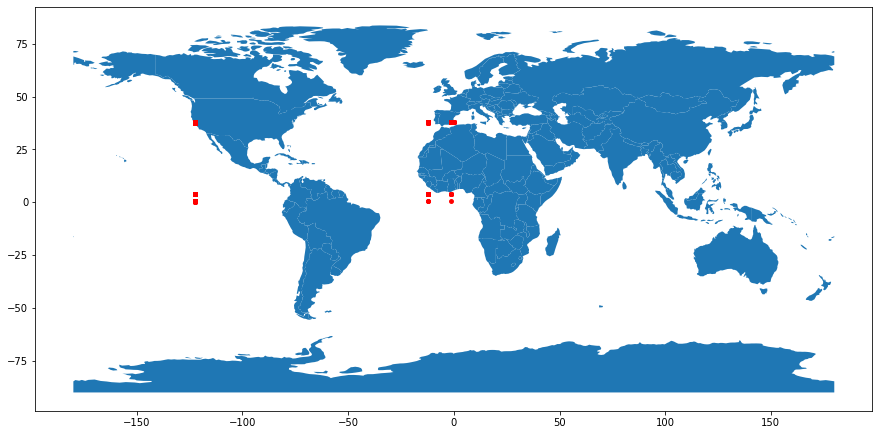

In [492]:
geometry = [Point(xy) for xy in zip(longitude,latitude)]
gdf = gpd.GeoDataFrame(df,geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15,15)),marker='o',color='r',markersize=15)

#### Correcao das colunas de latitude e longitude

In [493]:
df.latitude = df.latitude.apply(lambda x: float(str(x)[:2] + '.' + str(x).replace('.','')[2:]))
df.longitude = df.longitude.apply(lambda x: float(str(x)[:4] + '.' + str(x).replace('.','')[4:]))

In [494]:
df[['latitude','longitude']].head()

,latitude,longitude
0,37.76931,-122.43386
1,37.74511,-122.42102
2,37.76669,-122.45250
3,37.76487,-122.45183
4,37.77525,-122.43637


<AxesSubplot:>

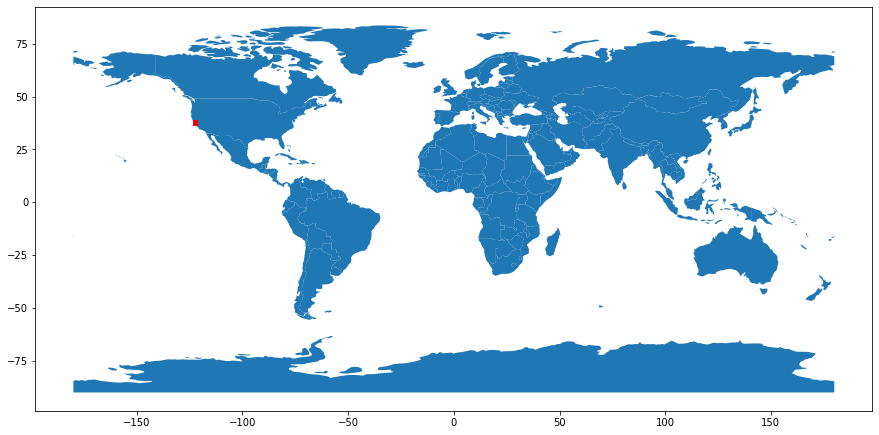

In [495]:
geometry = [Point(xy) for xy in zip(df.longitude,df.latitude)]
gdf = gpd.GeoDataFrame(df,geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(15,15)),marker='o',color='r',markersize=15)

#### Descobrindo cidades e bairros das propriedades pela latitude e longitude

Essa celula acima demora a rodar!!

In [496]:
geolocator = Nominatim(user_agent="geoapiExercises")
df['lat_lon'] = df.latitude.astype(str) + ',' + df.longitude.astype(str)
df['adress'] = df['lat_lon'].apply(lambda x:geolocator.reverse(x).raw['address'])

In [545]:
df=df2.copy()

In [546]:
a = df.loc[0,['adress']]
a[0]

{'railway': 'Sunset Tunnel East Portal',
 'road': 'Duboce Avenue',
 'neighbourhood': 'Western Addition',
 'city': 'San Francisco',
 'state': 'California',
 'ISO3166-2-lvl4': 'US-CA',
 'postcode': '94143',
 'country': 'United States',
 'country_code': 'us'}

#### Apos conferir o endereco podemos observar que praticamente todas as residencias se encontram em Sao Francisco, CA, US. As residencias que se encontram em outro municipio estao na fronteira entre os municipios

In [547]:
df['city'] = df['adress'].apply(lambda x: x.get('city', ''))

In [548]:
df.city.value_counts()

San Francisco    7140
Daly City           6
Name: city, dtype: int64

<AxesSubplot:>

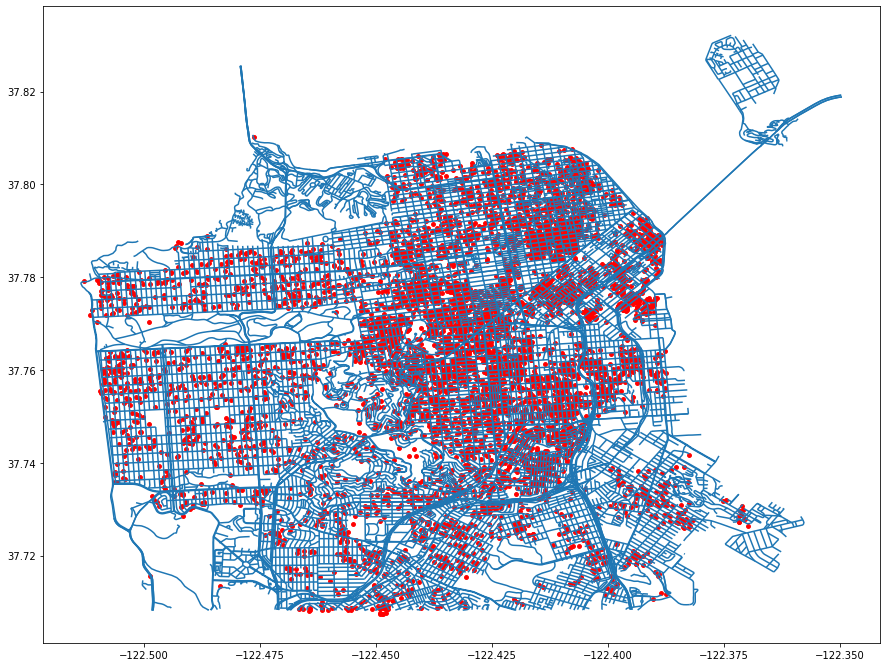

In [549]:
san_francisco = gpd.read_file('shapefiles/tl_2017_06075_roads.shp')
gdf.plot(ax=san_francisco.plot(figsize=(15,15)),marker='o',color='r',markersize=15)

#### Ja que praticamente todos sao da mesma cidade, extrai a informacao de bairros para ser uma feature categorica do nosso modelo

Observacao: No pdf que recebi "neighbourhood_cleansed" estava descrita como "limpeza do bairro", mas na realidade tinha nomes, que agora descobri que sao os bairros, mas de qualquer forma, como os dados estao sujos irei usar os bairros que extrai da biblioteca atualizada. E essa extracao foi util para se caso tiver cidades diferentes

In [550]:
df['neighbourhood'] = df['adress'].apply(lambda x: x.get('neighbourhood', ''))

In [551]:
df.groupby(['city','neighbourhood']).size()

city           neighbourhood    
Daly City                             6
San Francisco                       969
               Anza Vista             4
               Bayview District      85
               Bernal Heights       290
                                   ... 
               Union Square         324
               Visitacion Valley     21
               West Portal           42
               West SoMa            110
               Western Addition     671
Length: 63, dtype: int64

In [552]:
# Transformando espacos vazios em np.nan
df.city = df.city.replace('',np.nan)
df.neighbourhood = df.neighbourhood.replace('',np.nan)

In [553]:
df = df.loc[df.city != 'Daly City',:]

In [554]:
df[['city','neighbourhood']].head()

,city,neighbourhood
0,San Francisco,Western Addition
1,San Francisco,NaN
2,San Francisco,Cole Valley
3,San Francisco,Cole Valley
4,San Francisco,Western Addition


In [555]:
df = df.drop(columns=['neighbourhood_cleansed','city'])
df.to_csv('data/airbnb_data_with_location.csv')

#### Completando os bairros faltantes com um KNN simples. Ja que os pontos, no geral estao bem proximos e temos a latitude e longitude, podemos apenas descobrir o bairro olhando para os bairros dos pontos proximos, sem mesmo normalizar. Para o nosso contexto, mesmo nao sendo exatamente o mesmo bairro predito, tera caracteristicas similares 

In [556]:
df_with_ngbh = df.loc[df.neighbourhood.notna(),['latitude','longitude','neighbourhood']]
df_without_ngbh = df.loc[df.neighbourhood.isna(),['latitude','longitude']]

In [557]:
X = df_with_ngbh[['latitude','longitude']]
Y = df_with_ngbh.neighbourhood

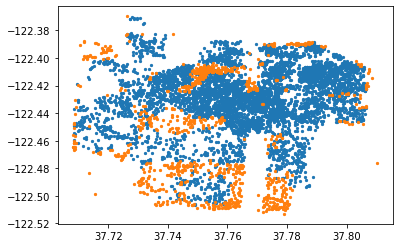

In [558]:
plt.scatter(X.latitude,X.longitude,s=5)
plt.scatter(df_without_ngbh.latitude,df_without_ngbh.longitude,s=5)

In [559]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X,Y)

KNeighborsClassifier(n_neighbors=3)

In [560]:
df_without_ngbh['neighbourhood'] = knn.predict(df_without_ngbh)

In [561]:
# Atualizando o DataFrame
df[['latitude','longitude','neighbourhood']] = pd.concat([df_with_ngbh,df_without_ngbh])

In [562]:
df.drop(columns=['adress','geometry','lat_lon'],inplace=True)

In [563]:
df.head()

,host_is_superhost,cancellation_policy,instant_bookable,host_total_listings_count,latitude,longitude,property_type,room_type,accommodates,bathrooms,...,bathrooms_na,beds_na,review_scores_rating_na,review_scores_accuracy_na,review_scores_cleanliness_na,review_scores_checkin_na,review_scores_communication_na,review_scores_location_na,review_scores_value_na,neighbourhood
0,t,moderate,t,1.0,37.76931,-122.43386,Apartment,Entire home/apt,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Western Addition
1,f,strict_14_with_grace_period,f,2.0,37.74511,-122.42102,Apartment,Entire home/apt,5.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Bernal Heights
2,f,strict_14_with_grace_period,f,10.0,37.76669,-122.45250,Apartment,Private room,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cole Valley
3,f,strict_14_with_grace_period,f,10.0,37.76487,-122.45183,Apartment,Private room,2.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cole Valley
4,f,strict_14_with_grace_period,f,2.0,37.77525,-122.43637,House,Entire home/apt,5.0,2022-05-01 00:00:00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Western Addition


### Data Cleansing

#### A descricao das features de review terminadas em "_na" diz que sao a quantidades de reviews sobre o topico especificado no nome da coluna e numero de outras coisas como quartos e banheiros, porem na realidade contem apenas valores de 0 e 1. Poderia ser uma informacao relevante para saber se a nota das reviews daquele topico era confiavel ou nao, mas nao poderei usar essas colunas "_na" por ser arriscado assumir qualquer coisa sobre elas, como, por exemplo, que 1 eh para confiavel e 0 para nao confiavel

In [564]:
df.filter(like='_na').apply(lambda x: x.unique(),axis=1).astype(str).unique()

array(['[0.]', '[0. 1.]', '[1. 0.]'], dtype=object)

In [565]:
df = df.drop(columns=df.filter(like='_na').columns.to_list())

#### Mapeando os valores 'f' e 't' para 0 e 1 nas features binarias

In [566]:
df[['host_is_superhost','instant_bookable']] = df.loc[:,['host_is_superhost','instant_bookable']].apply(lambda x: x.map({'f':0,'t':1}),axis=1)

#### A coluna "bathrooms" contem a quantidade de banheiros, mas esta com o tipo string e existem valores em datetime, corrigi trocando para np.nan os datetime e o resto para float, ja que tambem existem valores de 0.5, que pode ser apenas um lavabo

In [567]:
df.bathrooms.unique()

array(['1.0', '4.0', datetime.datetime(2022, 5, 1, 0, 0), '2.0', '3.0',
       '0.0', datetime.datetime(2022, 5, 2, 0, 0),
       datetime.datetime(2022, 5, 3, 0, 0), '0.5', '8.0', '10.0',
       datetime.datetime(2022, 5, 4, 0, 0), '14.0', '5.0',
       datetime.datetime(2022, 5, 5, 0, 0), '6.0'], dtype=object)

In [568]:
df.loc[df['bathrooms'].map(type) != str,['bathrooms']] = np.nan
df.bathrooms = df.bathrooms.astype(float)

In [569]:
df.bathrooms.unique()

array([ 1. ,  4. ,  nan,  2. ,  3. ,  0. ,  0.5,  8. , 10. , 14. ,  5. ,
        6. ])

#### Conferindo se ha tipos de dados errados

In [570]:
df.dtypes

host_is_superhost                int64
cancellation_policy             object
instant_bookable                 int64
host_total_listings_count      float64
latitude                       float64
longitude                      float64
property_type                   object
room_type                       object
accommodates                   float64
bathrooms                      float64
bedrooms                       float64
beds                           float64
bed_type                        object
minimum_nights                 float64
number_of_reviews              float64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
price                          float64
neighbourhood                   object
dtype: object

In [571]:
df.to_csv('data/airbnb_data_cleansed.csv')

### Transformando as features categoricas com One-Hot Encoding 

In [523]:
feat_cat = df.dtypes[df.dtypes == object].index
df[feat_cat] = df[feat_cat].astype("category")

df_feat_cat = df[feat_cat]
df_feat_cat = pd.get_dummies(df_feat_cat)
df = pd.concat([df.drop(columns=feat_cat),df_feat_cat],axis=1)

In [524]:
# df[df_feat_cat.columns] = df[df_feat_cat.columns].astype("category")

### Feature selection

#### Limpeza de nulos

In [525]:
to_drop = df.isna().mean()[df.isna().mean() > 0.15].index
df.drop(columns=to_drop,inplace=True)
to_drop

Index([], dtype='object')

#### Limpeza de baixa variancia

In [526]:
df_var = df.drop(columns=['latitude','longitude']).var()
to_drop = df_var[df_var<0.014].index
df.drop(columns=to_drop,inplace=True)
to_drop

Index(['cancellation_policy_strict', 'cancellation_policy_super_strict_30',
       'cancellation_policy_super_strict_60', 'property_type_Aparthotel',
       'property_type_Bed and breakfast', 'property_type_Boat',
       'property_type_Bungalow', 'property_type_Cabin', 'property_type_Castle',
       'property_type_Cottage', 'property_type_Earth house',
       'property_type_Guesthouse', 'property_type_Hostel',
       'property_type_Hotel', 'property_type_In-law', 'property_type_Loft',
       'property_type_Other', 'property_type_Resort',
       'property_type_Timeshare', 'property_type_Tiny house',
       'property_type_Treehouse', 'property_type_Villa', 'bed_type_Airbed',
       'bed_type_Couch', 'bed_type_Futon', 'bed_type_Pull-out Sofa',
       'bed_type_Real Bed', 'neighbourhood_Anza Vista',
       'neighbourhood_Bayview District', 'neighbourhood_Cow Hollow',
       'neighbourhood_Crocker-Amazon', 'neighbourhood_Dogpatch',
       'neighbourhood_Financial District', 'neighbourhood_F

#### Limpeza de alta correlacao entre features

In [527]:
corr_matrix = df.corr().abs()
corr_matrix.head()

,host_is_superhost,instant_bookable,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,minimum_nights,...,neighbourhood_Rincon Hill,neighbourhood_Russian Hill,neighbourhood_Seacliff,neighbourhood_South of Market,neighbourhood_St. Mary's Park,neighbourhood_Sunset District,neighbourhood_Tenderloin,neighbourhood_Union Square,neighbourhood_West SoMa,neighbourhood_Western Addition
host_is_superhost,1.000000,0.086987,0.063137,0.097716,0.055612,0.013276,0.039153,0.008947,0.033084,0.185265,...,0.063092,0.046829,0.002041,0.003188,0.013361,0.027039,0.083605,0.017788,0.004782,0.015635
instant_bookable,0.086987,1.000000,0.022020,0.013402,0.004283,0.055929,0.029252,0.083562,0.065333,0.044521,...,0.029352,0.016414,0.010836,0.019826,0.034157,0.026184,0.015434,0.074779,0.019836,0.000144
host_total_listings_count,0.063137,0.022020,1.000000,0.168907,0.179428,0.031820,0.001633,0.044224,0.070709,0.168092,...,0.124221,0.016193,0.036375,0.104580,0.033305,0.064616,0.060590,0.020360,0.082590,0.056601
latitude,0.097716,0.013402,0.168907,1.000000,0.185438,0.041179,0.034654,0.103041,0.048034,0.145562,...,0.117966,0.237390,0.077919,0.090433,0.201592,0.137149,0.158306,0.218582,0.052254,0.177427
longitude,0.055612,0.004283,0.179428,0.185438,1.000000,0.079264,0.006925,0.105799,0.088540,0.111227,...,0.180395,0.053370,0.327928,0.157459,0.034235,0.564589,0.104471,0.172678,0.104209,0.043100


In [528]:
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > 0.85)]

df.drop(columns=to_drop, inplace=True)
to_drop

/tmp/ipykernel_24971/2671505510.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


['room_type_Private room']

### Normalizacao

Como estamos trabalhando com XGBoost e ele eh um algoritmo baseado em Decision Trees, nao eh necessario normalizacao para esse caso, mas a implemetacao esta a seguir

In [544]:
# price_col = df.price
# df_without_price = df.drop(columns='price')
# df = pd.concat([df.price,df_without_price],axis=1)

# transformer = RobustScaler().fit(df)
# xy = transformer.transform(df)
# y = xy[:,0]
# X = xy[:,1:]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Separacao dos dados entre treino e teste

In [530]:
y = df.price
X = df.drop(columns='price')

In [531]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### Modelagem

O modelo escolhido foi o XGBoost por estar sendo muito bem recomendado devido sua otima performance em regressao e classificacao comparado a modelos de Machine Learning tradicionais

#### Parametros default

In [532]:
xgb.XGBRegressor().get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

#### Inicializacao e treino e predicao do XGBoost

In [533]:
# we initiate the regression model and train it with our train data
xg_reg = xgb.XGBRegressor()

# training the model
xg_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [534]:
xgb_preds = xg_reg.predict(X_test)

#### Plot comparativo do y_test e predicoes do xgboost

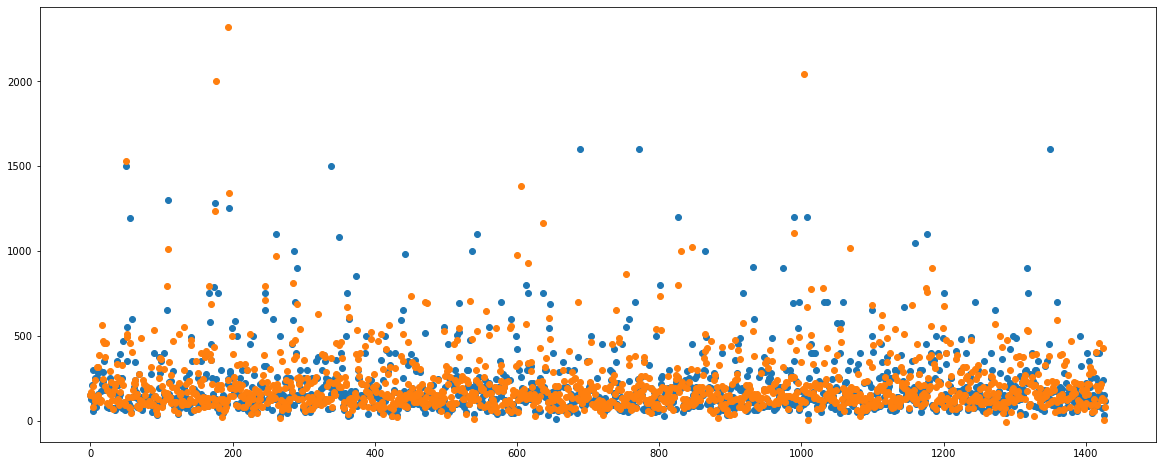

In [535]:
plt.figure(figsize=(20, 8))

plt.scatter([i for i in range(len(y_test))],y_test)
plt.scatter([i for i in range(len(y_test))],xgb_preds)

#### Resultados

In [536]:
print('R score is :', r2_score(y_test, xgb_preds))
print('MSE is :', mean_squared_error(y_test, xgb_preds))

R score is : 0.1931198732149053
MSE is : 28787.876508590292


In [537]:
pd.Series(index=df.drop(columns='price').columns,data=xg_reg.feature_importances_,name='feature_importance_xgb').sort_values(ascending=False).head(10)

neighbourhood_Chinatown           0.165023
bedrooms                          0.100253
neighbourhood_Mission District    0.065518
neighbourhood_Western Addition    0.047400
latitude                          0.044444
accommodates                      0.042932
property_type_Condominium         0.040332
host_total_listings_count         0.039545
minimum_nights                    0.037892
beds                              0.034823
Name: feature_importance_xgb, dtype: float32

In [538]:
pd.DataFrame({'y_test':y_test,'xgb_preds':xgb_preds}).reset_index(drop=True).head()

,y_test,xgb_preds
0,150.0,150.495178
1,129.0,168.277847
2,210.0,153.039917
3,299.0,202.004272
4,55.0,80.880676


### Comparacao com uma Regressao Linear Multipla

#### Normalizacao, pois a regressao necessita. Utilizei o RobustScaler do sklearn por ser bem resiliente a outliers

In [539]:
# Tirando valores nulos, ja que nao precisei tirar antes devido ao XGBoost suportar valores faltantes
df.dropna(inplace=True)

price_col = df.price
df_without_price = df.drop(columns='price')
df = pd.concat([df.price,df_without_price],axis=1)

transformer = RobustScaler().fit(df)
xy = transformer.transform(df)
y = xy[:,0]
X = xy[:,1:]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

#### Inicializacao e treino e predicao da Regressao

In [540]:
mlr = LinearRegression()

mlr.fit(X_train,y_train)
mlr_preds = mlr.predict(X_test)

#### Plot comparativo do y_test e predicoes da regressao linear multipla

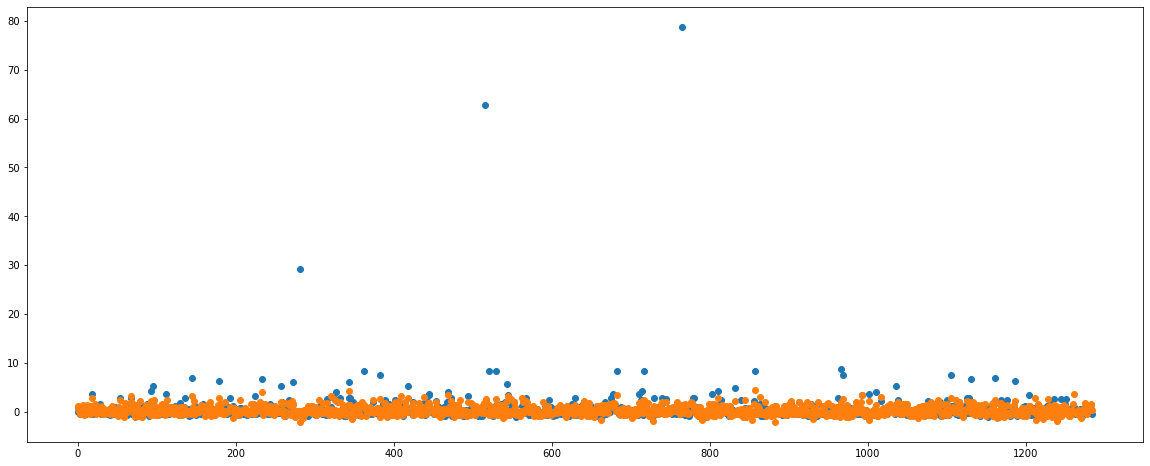

In [541]:
plt.figure(figsize=(20, 8))

plt.scatter([i for i in range(len(y_test))],y_test)
plt.scatter([i for i in range(len(y_test))],mlr_preds)

#### Resultados

In [542]:
print('R score is :', r2_score(y_test, mlr_preds))
print('MSE is :', mean_squared_error(y_test, mlr_preds), '(lembrando que esse mse esta ordens de magnitude menor devido a normalizacao)')

R score is : 0.06638445676337579
MSE is : 9.390200803835198 (lembrando que esse mse esta ordens de magnitude menor devido a normalizacao)


#### Importancia das features em ordem decrescente

In [543]:
pd.Series(index=df.drop(columns='price').columns,data=mlr.coef_,name='feature_importance_mlr').sort_values(ascending=False).head(10)

accommodates                                       0.510585
latitude                                           0.477449
bedrooms                                           0.464434
neighbourhood_Rincon Hill                          0.399480
room_type_Entire home/apt                          0.389999
cancellation_policy_strict_14_with_grace_period    0.385828
property_type_Condominium                          0.357308
cancellation_policy_flexible                       0.355313
neighbourhood_South of Market                      0.330450
cancellation_policy_moderate                       0.287406
Name: feature_importance_mlr, dtype: float64

### Conclusao

#### XGBoost vs Regressao Linear

Ainda precisariamos fazer muito mais testes para definir qual modelo performa melhor para esse caso, nao apenas mais comparacoes, mas tambem fazer um tunning de hiperparametros para esse caso especifico. Dito isso, o XGBoost ganhou muita atencao nos ultimos anos pela sua performance em competicoes e na literatura recente, entao o resultado esperado eh que ele performe melhor

#### Colocar o modelo em producao

Apos essa primeira fase de desenvolvimento e experimentacao ainda teriamos que fazer grid searches para descobrir os melhores parametros pra o XGBoost, alem de comparar com outros modelos, ate mesmo uma rede neural, caso obtivermos mais dados. 

Completando a fase de experimentacao inicial, poderiamos transformar o codigo em uma ou mais classes num script .py, para garantir melhor perfoescalabilidade e reutilizacao.

#### Utilizacao do modelo

Tal modelo pode ser fornecido como uma ferramenta para proprietarios que anunciam seus imoveis no airbnb como uma forma de descobrir um preco que faca sentido para a diaria de seu imovel na plataforma. Alem disso, se tambem obtivermos os dados de taxa de ocupacao, poderiamos ter uma melhor recomendacao dos precos para os proprietarios usando a taxa de ocupacao como um proxy de qualidade do preco. Poderiamos treinar um modelo apenas com os dados dos anuncios que tem uma taxa de ocupacao alta para fornecer uma recomendacao de preco que traria tais resultados.